In [181]:
%pip install scikit-learn xgboost imbalanced-learn

import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import recall_score, roc_auc_score

# df_trn = pd.read_csv("../data/guiDataCleanInfill0Treino.csv")
# df_tst = pd.read_csv("../data/guiDataCleanInfill0Teste.csv")

# df_trn = pd.read_csv("../data/guiDataCleanKNNTreino.csv")
# df_tst = pd.read_csv("../data/guiDataCleanKNNTeste.csv")

df_trn = pd.read_csv("../data/guiDataCleanMaxDataTreino.csv")
df_tst = pd.read_csv("../data/guiDataCleanMaxDataTeste.csv")

Note: you may need to restart the kernel to use updated packages.


In [182]:
def split_X_y(df, target='nr_abandono'):
    """
    Separa as features (X) e o alvo (y) de um DataFrame.

    Parâmetros:
    - df: DataFrame de entrada.
    - target: nome da coluna alvo.

    Retorna:
    - X: DataFrame com as features.
    - y: Series com a coluna alvo.
    """
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

X_train, y_train = split_X_y(df_trn)
X_test, y_test = split_X_y(df_tst)

pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42))
])


In [183]:
# Treinar o modelo base
pipeline_rf.fit(X_train, y_train)
 
# Selecionar as 10 features mais importantes
def select_top_features(model, X_train, X_test, top_n=10):
    # Obter as importâncias das features do estimador final do pipeline
    feature_importances = model.named_steps['rfc'].feature_importances_
    feature_names = X_train.columns

    # Criar um DataFrame para as importâncias
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Selecionar as top_n features
    top_features = importances_df.head(top_n)['Feature'].tolist()

    # Filtrar os dados de treinamento e teste para incluir apenas as top_n features
    X_train = X_train[top_features]
    X_test = X_test[top_features]

    print("Top 10 Features Selecionadas:")
    print(importances_df.head(top_n))

    return X_train, X_test
 
X_train, X_test = select_top_features(pipeline_rf, X_train, X_test)


Top 10 Features Selecionadas:
                          Feature  Importance
1     nr_dias_desde_ultimo_acesso    0.223606
34          vl_dias_entre_acessos    0.177074
0   nr_dias_desde_primeiro_acesso    0.129149
27       nr_itens_nao_respondidos    0.073226
11                    nr_dias_uso    0.037741
6    nr_questionarios_finalizados    0.032363
12      vl_medio_atividade_diaria    0.031227
28                 vl_media_notas    0.031185
10              nr_intervalos_uso    0.025993
17       nr_engajamento_discussao    0.019926


In [184]:
#descobrir os melhores hiperparâmetros para random forest
param_dist = {
    'rfc__n_estimators': [100, 200, 300, 400, 500],
    'rfc__max_depth': [None, 10, 20, 30, 40, 50],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',
    verbose=2,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # Validação cruzada estratificada
    random_state=42,
    n_jobs=-1
)

In [185]:
# Função para rankear modelos com base em recall e roc_auc
def rank_models(metrics_list):
    # Criar DataFrame com métricas
    metrics_df = pd.DataFrame(metrics_list)
    
    # Rankear os modelos com base em recall e roc_auc
    metrics_df['recall_rank'] = metrics_df['recall'].rank(ascending=False)
    metrics_df['roc_auc_rank'] = metrics_df['roc_auc'].rank(ascending=False)
    
    # Calcular a soma das posições
    metrics_df['rank_sum'] = metrics_df['recall_rank'] + metrics_df['roc_auc_rank']
    
    # Selecionar o modelo com a menor soma das posições
    best_model_index = metrics_df['rank_sum'].idxmin()
    best_model_metrics = metrics_df.loc[best_model_index]
    
    print("\nMelhor modelo:")
    print(best_model_metrics, "\n")
    
    return best_model_index, best_model_metrics
 
# Realizar RandomizedSearchCV
random_search.fit(X_train, y_train)
 
# Avaliar os modelos gerados
metrics_list = []
for params, mean_test_score, std_test_score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score'], random_search.cv_results_['std_test_score']):
    model = random_search.best_estimator_
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    metrics_list.append({
        'params': params,
        'recall': recall,
        'roc_auc': roc_auc
    })

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END rfc__bootstrap=False, rfc__max_depth=50, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   0.2s
[CV] END rfc__bootstrap=False, rfc__max_depth=50, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   0.2s
[CV] END rfc__bootstrap=False, rfc__max_depth=50, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   0.3s
[CV] END rfc__bootstrap=False, rfc__max_depth=50, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   0.3s
[CV] END rfc__bootstrap=True, rfc__max_depth=10, rfc__min_samples_leaf=4, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   0.3s
[CV] END rfc__bootstrap=False, rfc__max_depth=50, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   0.3s
[CV] END rfc__bootstrap=True, rfc__max_depth=10, rfc__min_samples_leaf=4, 

In [186]:
# melhor modelo
best_model_index, best_model_metrics = rank_models(metrics_list)

#melhores parametros encontrados recall, roc_auc, precision, f1
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("Melhor score de validação (ROC AUC):")
print(random_search.best_score_)
from sklearn.metrics import classification_report, confusion_matrix
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))



Melhor modelo:
params          {'rfc__n_estimators': 500, 'rfc__min_samples_s...
recall                                                   0.785714
roc_auc                                                  0.997768
recall_rank                                                  50.5
roc_auc_rank                                                 50.5
rank_sum                                                    101.0
Name: 0, dtype: object 

Melhores parâmetros encontrados:
{'rfc__n_estimators': 500, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 2, 'rfc__max_depth': 40, 'rfc__bootstrap': False}
Melhor score de validação (ROC AUC):
1.0
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.79      0.88        14

    accuracy                           0.93        46
   macro avg       0.96      0.89      0.92        46
weighted avg       0.94      0.93      0.93        46



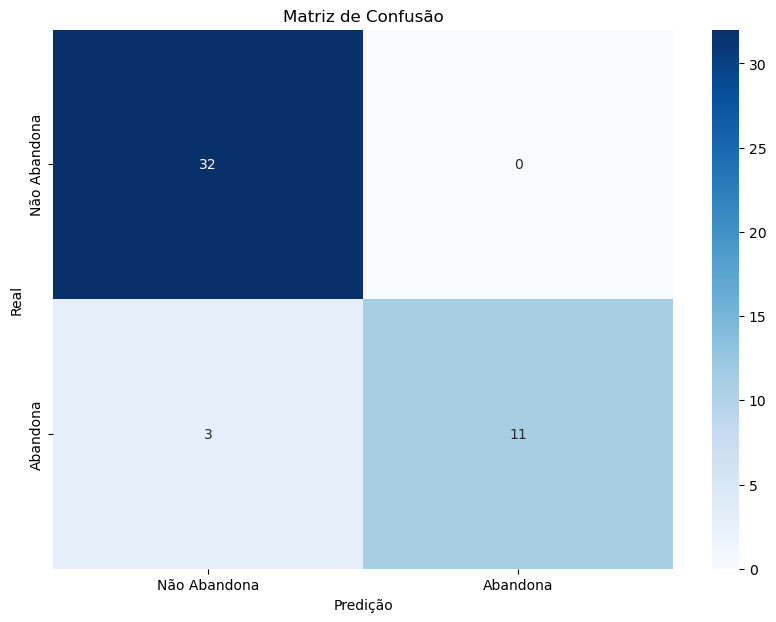

In [187]:
# visualizar os resultados
import matplotlib.pyplot as plt
import seaborn as sns
# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Abandona', 'Abandona'], yticklabels=['Não Abandona', 'Abandona'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

In [188]:
# verificar overfitting se ocorreu overfitting
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train, random_search.predict(X_train))
test_auc = roc_auc_score(y_test, y_pred)
print(f"AUC no conjunto de treino: {train_auc:.4f}")
print(f"AUC no conjunto de teste: {test_auc:.4f}")

AUC no conjunto de treino: 1.0000
AUC no conjunto de teste: 0.8929


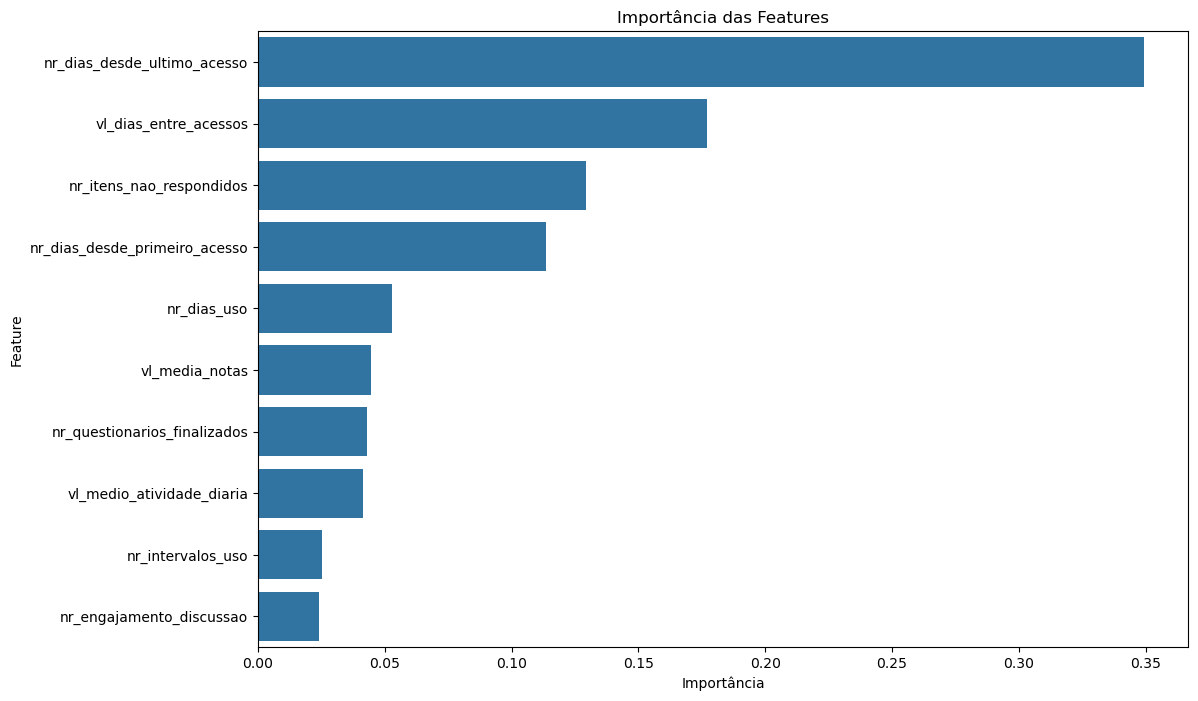

In [189]:
# visualizar importancia das features com nomes
importances = random_search.best_estimator_.named_steps['rfc'].feature_importances_
feature_names = X_train.columns
# Criar um DataFrame para as importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Ordenar por importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotar as importâncias
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()  

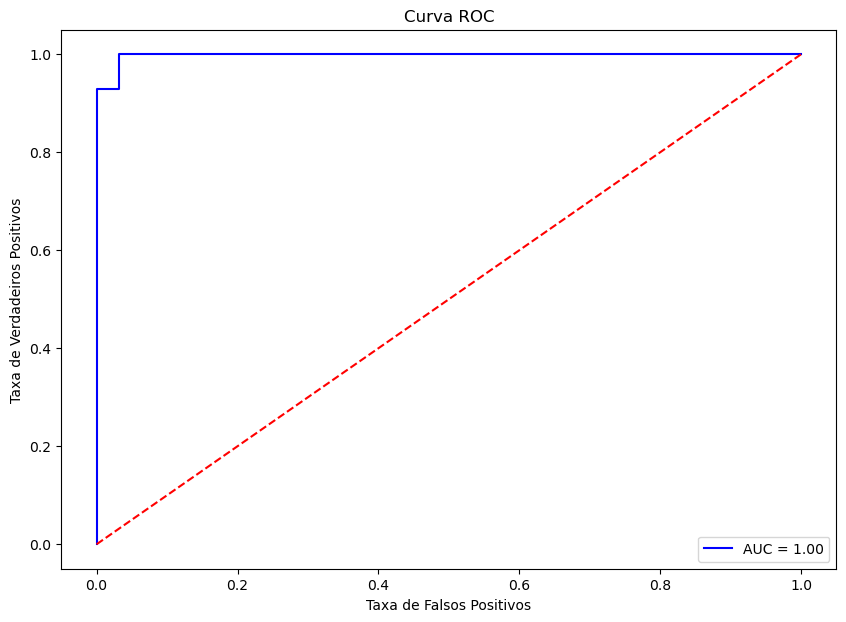

In [190]:
# Plotar a curva ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, random_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.show()

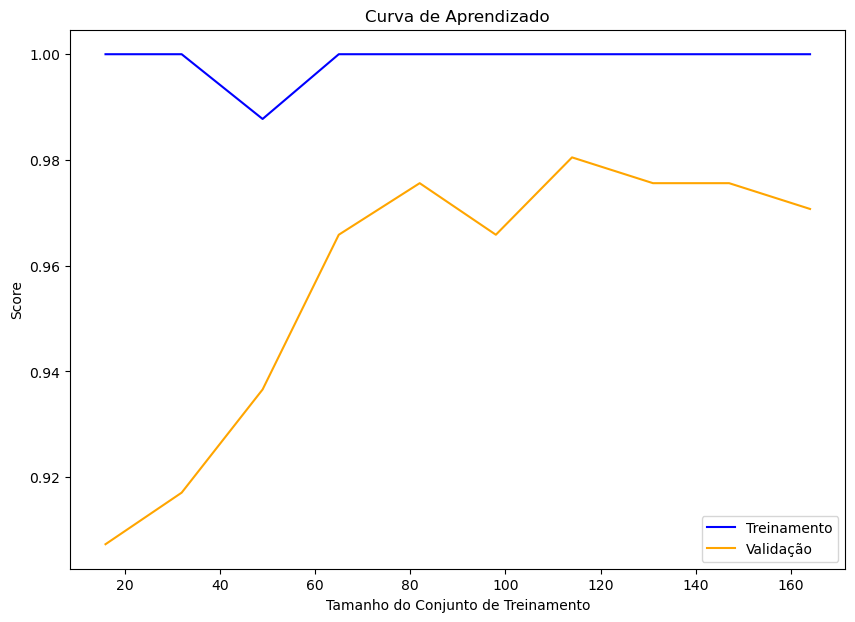

In [191]:
# Plotar a curva de aprendizado
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    random_search.best_estimator_, X_train, y_train,
    cv=5, n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validação', color='orange')
plt.title('Curva de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Score')
plt.legend()
plt.show()